## Setup

### Import Libraries

In [1]:
import pickle
from datasets import load_from_disk
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
from pathlib import Path
import json
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
import matplotlib.pyplot as plt
from datetime import datetime
import os
import glob

/opt/anaconda3/envs/gen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Data

In [2]:
# Load split indices
with open('./cache/splits.pkl', 'rb') as f:
    splits = pickle.load(f)

train_indices = splits['train_indices']
val_indices = splits['val_indices']
test_indices = splits['test_indices']

# Load dataset and create splits
dataset = load_from_disk("./data")
train_split = dataset["labelled"].select(train_indices)
val_split = dataset["labelled"].select(val_indices)
test_split = dataset["labelled"].select(test_indices)

### PyTorch Transformations

In [3]:
# Define ImageNet normalisation constants (for pretrained ResNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Create a custom class for the segmentation transforms
class SegmentationTransform:
    def __init__(self, image_size=512, augment=False):
        self.image_size = image_size
        self.augment = augment
    
    def __call__(self, image, mask):
        # Resize image and mask to the same size
        resize_image = transforms.Resize((self.image_size, self.image_size), 
                                   interpolation=transforms.InterpolationMode.BILINEAR) # Smoothing for image
        resize_mask = transforms.Resize((self.image_size, self.image_size),
                                        interpolation=transforms.InterpolationMode.NEAREST) # Nearest neighbour for mask
        
        image = resize_image(image)
        mask = resize_mask(mask)
        
        # Augment training data (improves generalisation and reduces overfitting)
        if self.augment:
            # Random horizontal flip
            if np.random.random() > 0.5:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)
            
            # Random rotation
            angle = np.random.uniform(-15, 15)
            image = transforms.functional.rotate(image, angle, 
                                                 interpolation=transforms.InterpolationMode.BILINEAR) # Smoothing for image
            mask = transforms.functional.rotate(mask, angle,
                                                interpolation=transforms.InterpolationMode.NEAREST) # Nearest neighbour for mask
            
            # Random colour jitter
            color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            image = color_jitter(image)
        
        return image, mask

# Create a custom class for the GWFSS dataset
class GWFSSDataset(Dataset):
    def __init__(self, dataset_split, transform=None):
        self.dataset = dataset_split
        self.transform = transform
        self.rgb_to_class = {
            (0, 0, 0): 0,
            (214, 255, 50): 1,
            (50, 132, 255): 2,
            (50, 255, 132): 3,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example['image']
        mask_rgb = example['mask']
        mask_array = np.array(mask_rgb)

        # Create an empty array with the same dimensions as the mask to store the class labels
        mask = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)

        # For each RGB colour in the mapping, set the corresponding pixels in the mask to the class label
        for rgb_tuple, class_id in self.rgb_to_class.items():
            mask[(mask_array == rgb_tuple).all(axis=2)] = class_id
        
        # Convert the mask array to a greyscale PIL Image
        mask = Image.fromarray(mask, mode='L')
        
        # Transform image and mask (done together to maintain alignment)
        if self.transform:
            image, mask = self.transform(image, mask)
        
        # Convert to tensors
        image = transforms.ToTensor()(image)
        mask = torch.from_numpy(np.array(mask)).long()
        
        # Normalise image
        normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        image = normalize(image)
        
        return image, mask

In [4]:
# Create transforms
train_transform = SegmentationTransform(image_size=512, augment=True)
val_transform = SegmentationTransform(image_size=512, augment=False)
test_transform = SegmentationTransform(image_size=512, augment=False)

# Use transforms to create datasets
train_dataset = GWFSSDataset(train_split, transform=train_transform)
val_dataset = GWFSSDataset(val_split, transform=val_transform)
test_dataset = GWFSSDataset(test_split, transform=test_transform)

print(f"✓ Created PyTorch datasets:")
print(f"  Train: {len(train_dataset)} examples")
print(f"  Val: {len(val_dataset)} examples")
print(f"  Test: {len(test_dataset)} examples")

✓ Created PyTorch datasets:
  Train: 767 examples
  Val: 164 examples
  Test: 165 examples


### DataLoaders

In [5]:
# Set batch size
BATCH_SIZE = 8

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"✓ Created DataLoaders with batch size {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ Created DataLoaders with batch size 8
  Train batches: 96
  Val batches: 21
  Test batches: 21


### Training Config

In [6]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✓ Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU")

✓ Using MPS (Apple Silicon)


In [7]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set hyperparameters
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
MIN_LEARNING_RATE = 1e-6
NUM_EPOCHS = 50
NUM_CLASSES = 4

print(f"Hyperparameters:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Minimum learning rate: {MIN_LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Image size: 512x512")

Hyperparameters:
  Learning rate: 0.0001
  Weight decay: 0.0001
  Minimum learning rate: 1e-06
  Epochs: 50
  Batch size: 8
  Image size: 512x512


In [8]:
# Create DeepLabV3+ with ResNet50 encoder
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3, # RGB images
    classes=NUM_CLASSES,
)

# Move model to device
model = model.to(device)

print("✓ Created DeepLabV3+ model with ResNet50 encoder")
print(f"  Encoder: ResNet50 (ImageNet pretrained)")
print(f"  Classes: {NUM_CLASSES}")
print(f"  Device: {device}")

✓ Created DeepLabV3+ model with ResNet50 encoder
  Encoder: ResNet50 (ImageNet pretrained)
  Classes: 4
  Device: mps


In [9]:
# Load class counts from cache
class_counts_path = Path("./cache/class_counts.json")
with open(class_counts_path, 'r') as f:
    class_counts_dict = json.load(f)

# Sum the number of pixels for each class in the training set
train_class_totals = [0, 0, 0, 0]
for idx in train_indices:
    for class_id in range(4):
        train_class_totals[class_id] += class_counts_dict[str(class_id)][idx]

# Calculate inverse frequency weights
total_pixels = sum(train_class_totals)
class_weights = [total_pixels / (NUM_CLASSES * count) for count in train_class_totals]

# Normalise to background (makes weights easier to interpret)
class_weights = [w / class_weights[0] for w in class_weights]

# Convert to tensor for use in loss function
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class distribution in training set:")
class_names = ['Background', 'Leaf', 'Stem', 'Head']
for i, name in enumerate(class_names):
    pct = 100 * train_class_totals[i] / total_pixels
    print(f"  {name}: {pct:.1f}% (weight: {class_weights[i]:.2f}x)")

Class distribution in training set:
  Background: 37.6% (weight: 1.00x)
  Leaf: 50.0% (weight: 0.75x)
  Stem: 3.7% (weight: 10.25x)
  Head: 8.7% (weight: 4.34x)


In [10]:
# Use Cross-Entropy Loss with class weights (great for sementatic segmentation of imbalanced datasets)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

print(f"✓ Using CrossEntropyLoss with class weights")

✓ Using CrossEntropyLoss with class weights


In [11]:
# AdamW optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Cosine annealing scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=MIN_LEARNING_RATE)

print(f"✓ Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"✓ Scheduler: CosineAnnealingLR (T_max={NUM_EPOCHS}, eta_min={MIN_LEARNING_RATE})")

✓ Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
✓ Scheduler: CosineAnnealingLR (T_max=50, eta_min=1e-06)


In [12]:
# Define IoU metric
def calculate_iou(pred_mask, true_mask, num_classes=4):
    ious = []
    pred_mask = pred_mask.cpu().numpy()
    true_mask = true_mask.cpu().numpy()
    
    for cls in range(num_classes):
        # Create binary masks
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        
        # Use masks to calculate intersection and union
        intersection = np.logical_and(pred_cls, true_cls).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        
        # Handle division by zero if class is not present in either mask
        if union == 0:
            # Both masks correctly have no pixels of this class → perfect IoU
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union

        ious.append(iou)
    
    return ious

print("✓ Defined IoU metric")

✓ Defined IoU metric


In [13]:
# Define training function
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    
    running_loss = 0.0
    all_ious = [[], [], [], []]  # Store IoUs for each class
    
    for batch_idx, (images, masks) in enumerate(loader):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        
        # Calculate IoU
        predictions = torch.argmax(outputs, dim=1)
        batch_ious = calculate_iou(predictions, masks, num_classes=NUM_CLASSES)
        for cls in range(NUM_CLASSES):
            if not np.isnan(batch_ious[cls]):
                all_ious[cls].append(batch_ious[cls])
    
    # Calculate average loss and mIoU
    avg_loss = running_loss / len(loader)
    class_ious = [np.mean(ious) if ious else float('nan') for ious in all_ious]
    miou = np.nanmean(class_ious)
    
    return avg_loss, miou, class_ious

# Define validation function
def validate(model, loader, criterion, device):
    model.eval()
    
    running_loss = 0.0
    all_ious = [[], [], [], []]  # Store IoUs for each class
    
    with torch.no_grad():
        for images, masks in loader:
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Track loss
            running_loss += loss.item()
            
            # Calculate IoU
            predictions = torch.argmax(outputs, dim=1)
            batch_ious = calculate_iou(predictions, masks, num_classes=NUM_CLASSES)
            for cls in range(NUM_CLASSES):
                if not np.isnan(batch_ious[cls]):
                    all_ious[cls].append(batch_ious[cls])
    
    # Calculate average loss and mIoU
    avg_loss = running_loss / len(loader)
    class_ious = [np.mean(ious) if ious else float('nan') for ious in all_ious]
    miou = np.nanmean(class_ious)
    
    return avg_loss, miou, class_ious


print("✓ Defined training and validation functions")

✓ Defined training and validation functions


## Training

### Baseline

In [14]:
# Track best model
best_val_miou = 0.0
best_epoch = 0

# Store history
history = {
    'train_loss': [],
    'train_miou': [],
    'val_loss': [],
    'val_miou': [],
    'train_class_ious': [],
    'val_class_ious': []
}

print(f"\nStarting training for {NUM_EPOCHS} epochs...\n")
print("=" * 80)

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_miou, train_class_ious = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_miou, val_class_ious = validate(
        model, val_loader, criterion, device
    )
    
    # Step scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_miou'].append(train_miou)
    history['val_loss'].append(val_loss)
    history['val_miou'].append(val_miou)
    history['train_class_ious'].append(train_class_ious)
    history['val_class_ious'].append(val_class_ious)
    
    # Track best model
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        best_epoch = epoch
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_miou': val_miou,
        }, './cache/best_model.pth')
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.1f}s)")
    print(f"  Train Loss: {train_loss:.4f} | Train mIoU: {train_miou:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val mIoU:   {val_miou:.4f}")
    print(f"  Val IoUs - BG: {val_class_ious[0]:.3f}, Leaf: {val_class_ious[1]:.3f}, "
          f"Stem: {val_class_ious[2]:.3f}, Head: {val_class_ious[3]:.3f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    if val_miou == best_val_miou:
        print(f"  ⭐ Best model!")
    print("-" * 80)

print("\n" + "=" * 80)
print(f"Training complete!")
print(f"Best Val mIoU: {best_val_miou:.4f} (Epoch {best_epoch+1})")


Starting training for 50 epochs...

Epoch [1/50] (158.8s)
  Train Loss: 0.9334 | Train mIoU: 0.3487
  Val Loss:   0.7091 | Val mIoU:   0.4095
  Val IoUs - BG: 0.524, Leaf: 0.448, Stem: 0.103, Head: 0.562
  LR: 0.000100
  ⭐ Best model!
--------------------------------------------------------------------------------
Epoch [2/50] (153.8s)
  Train Loss: 0.6815 | Train mIoU: 0.4583
  Val Loss:   0.6081 | Val mIoU:   0.4814
  Val IoUs - BG: 0.641, Leaf: 0.502, Stem: 0.140, Head: 0.642
  LR: 0.000100
  ⭐ Best model!
--------------------------------------------------------------------------------
Epoch [3/50] (151.3s)
  Train Loss: 0.6278 | Train mIoU: 0.4843
  Val Loss:   0.5847 | Val mIoU:   0.4907
  Val IoUs - BG: 0.651, Leaf: 0.516, Stem: 0.162, Head: 0.633
  LR: 0.000099
  ⭐ Best model!
--------------------------------------------------------------------------------
Epoch [4/50] (152.3s)
  Train Loss: 0.5628 | Train mIoU: 0.5142
  Val Loss:   0.5145 | Val mIoU:   0.5399
  Val IoUs - BG: 

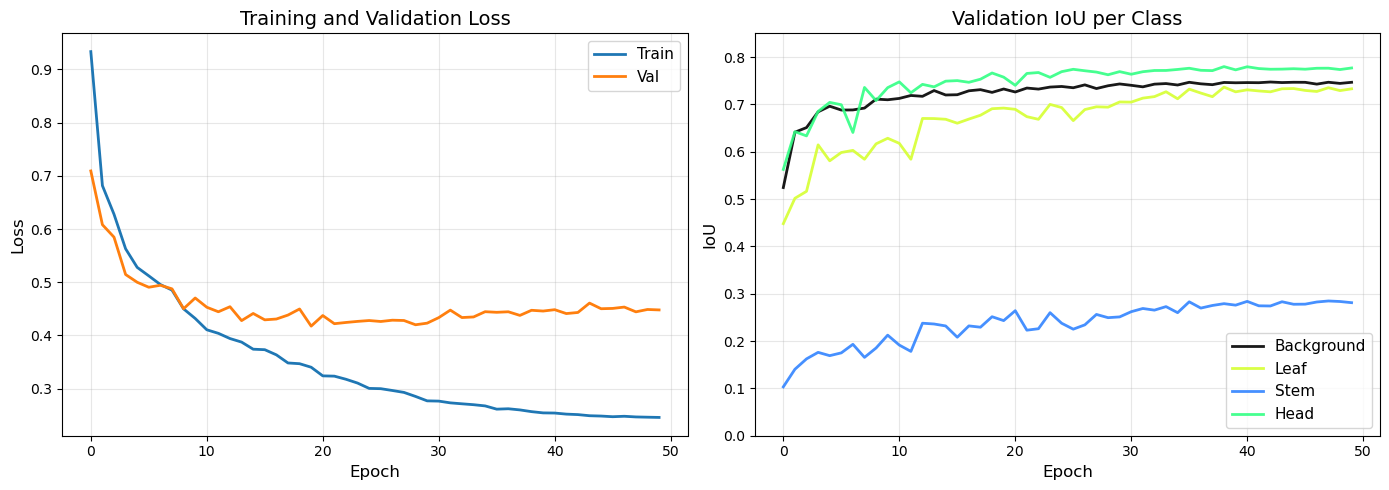

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Per-class IoU (validation only)
val_class_ious_array = np.array(history['val_class_ious'])

# Match the RGB mask colors
mask_colors = [
    '#000000',              # Background: Black
    '#D6FF32',              # Leaf: Yellow-green
    '#3284FF',              # Stem: Blue
    '#32FF84',              # Head: Cyan-green
]

for cls, name in enumerate(class_names):
    axes[1].plot(val_class_ious_array[:, cls], label=name, linewidth=2, 
                 color=mask_colors[cls], alpha=0.9)

# Add target lines
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('IoU', fontsize=12)
axes[1].set_title('Validation IoU per Class', fontsize=14)
axes[1].legend(fontsize=11, loc='lower right')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 0.85])

plt.tight_layout()
plt.show()

In [16]:
# Create experiment name
experiment_name = "01_baseline"

# Clean up any old versions of the experiment
old_files = glob.glob(f'./cache/{experiment_name}.pth') + glob.glob(f'./cache/{experiment_name}_summary.json')
for f in old_files:
    os.remove(f)
    print(f"✓ Removed old version: {f}")

# Load the best model that was saved during training
best_model_path = './cache/best_model.pth'
if os.path.exists(best_model_path):
    best_checkpoint = torch.load(best_model_path, weights_only=False)
    print(f"✓ Found best_model.pth from epoch {best_checkpoint['epoch']+1}")
else:
    print("⚠ No best_model.pth found, using current model state")
    best_checkpoint = {
        'epoch': best_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_miou': best_val_miou,
    }

# Save complete checkpoint
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_path = f'./cache/{experiment_name}.pth'
torch.save({
    'experiment_name': experiment_name,
    'timestamp': timestamp,
    'epoch': best_checkpoint['epoch'],
    'model_state_dict': best_checkpoint['model_state_dict'],
    'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
    'scheduler_state_dict': scheduler.state_dict(),
    'best_val_miou': best_val_miou,
    'final_val_miou': history['val_miou'][-1],
    'history': history,
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'image_size': 512,
        'encoder': 'resnet50',
        'loss': 'CrossEntropyLoss',
        'class_weights': class_weights,
    },
    'final_results': {
        'train_loss': history['train_loss'][-1],
        'val_loss': history['val_loss'][-1],
        'train_miou': history['train_miou'][-1],
        'val_miou': history['val_miou'][-1],
        'val_class_ious': history['val_class_ious'][-1],
    }
}, checkpoint_path)

print(f"✓ Saved complete checkpoint: {checkpoint_path}")

# Save summary as JSON
summary = {
    'experiment_name': experiment_name,
    'timestamp': timestamp,
    'best_epoch': int(best_epoch + 1),
    'total_epochs': len(history['train_loss']),
    'best_val_miou': float(best_val_miou),
    'final_val_miou': float(history['val_miou'][-1]),
    'final_val_class_ious': {
        'background': float(history['val_class_ious'][-1][0]),
        'leaf': float(history['val_class_ious'][-1][1]),
        'stem': float(history['val_class_ious'][-1][2]),
        'head': float(history['val_class_ious'][-1][3]),
    },
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'image_size': 512,
        'encoder': 'resnet50',
        'loss': 'CrossEntropyLoss',
        'class_weights': class_weights,
    },
    'training_time_minutes': 127,
}

summary_path = f'./cache/{experiment_name}_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved summary: {summary_path}")

# Delete best_model.pth
if os.path.exists(best_model_path):
    os.remove(best_model_path)
    print(f"✓ Cleaned up best_model.pth (archived in experiment file)")

# Print summary
print("\n" + "="*70)
print(f"EXPERIMENT SAVED: {experiment_name}")
print("="*70)
print(f"Timestamp: {timestamp}")
print(f"Best Val mIoU: {best_val_miou:.4f} (Epoch {best_epoch+1})")
print(f"Final Val mIoU: {history['val_miou'][-1]:.4f}")
print(f"Training time: 127 minutes")

✓ Removed old version: ./cache/01_baseline.pth
✓ Removed old version: ./cache/01_baseline_summary.json
✓ Found best_model.pth from epoch 48
✓ Saved complete checkpoint: ./cache/01_baseline.pth
✓ Saved summary: ./cache/01_baseline_summary.json
✓ Cleaned up best_model.pth (archived in experiment file)

EXPERIMENT SAVED: 01_baseline
Timestamp: 20251228_133838
Best Val mIoU: 0.6357 (Epoch 48)
Final Val mIoU: 0.6343
Training time: 127 minutes


As in the literature, poor stem segmentation hindered overall performance. For the next experiment, stem class weight will be boosted by an additional 1.5x multiplier, Dice Loss will be used instead of Cross-Entropy (better for thin objects), and early stopping will be implemented to account for the performance plateau observed at epoch 30.

### Dice Loss + Increased Stem Weight

In [17]:
# Use Dice Loss
criterion = smp.losses.DiceLoss(mode='multiclass', classes=NUM_CLASSES)

# Calculate inverse frequency weights
total_pixels = sum(train_class_totals)
class_weights = [total_pixels / (NUM_CLASSES * count) for count in train_class_totals]

# Boost stem weight even more
class_weights = [w / class_weights[0] for w in class_weights]
class_weights[2] = class_weights[2] * 1.5  # Multiply stem weight by 1.5x

# Convert to tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [18]:
# Define maximum number of epochs
NUM_EPOCHS = 30

# Stop early if no improvement for 10 epochs
PATIENCE = 10
patience_counter = 0

In [19]:
# Track best model
best_val_miou = 0.0
best_epoch = 0

# Store history
history = {
    'train_loss': [],
    'train_miou': [],
    'val_loss': [],
    'val_miou': [],
    'train_class_ious': [],
    'val_class_ious': []
}

print(f"\nStarting training for up to {NUM_EPOCHS} epochs...")
print(f"Early stopping: patience = {PATIENCE} epochs\n")
print("=" * 80)

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_miou, train_class_ious = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_miou, val_class_ious = validate(
        model, val_loader, criterion, device
    )
    
    # Step scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_miou'].append(train_miou)
    history['val_loss'].append(val_loss)
    history['val_miou'].append(val_miou)
    history['train_class_ious'].append(train_class_ious)
    history['val_class_ious'].append(val_class_ious)
    
    # Track best model and early stopping
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        best_epoch = epoch
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_miou': val_miou,
        }, './cache/best_model.pth')
        best_marker = "⭐ Best model!"
    else:
        patience_counter += 1
        best_marker = ""
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.1f}s)")
    print(f"  Train Loss: {train_loss:.4f} | Train mIoU: {train_miou:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val mIoU:   {val_miou:.4f}")
    print(f"  Val IoUs - BG: {val_class_ious[0]:.3f}, Leaf: {val_class_ious[1]:.3f}, "
          f"Stem: {val_class_ious[2]:.3f}, Head: {val_class_ious[3]:.3f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f} | Patience: {patience_counter}/{PATIENCE}")
    if best_marker:
        print(f"  {best_marker}")
    print("-" * 80)
    
    # Check for early stopping
    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping triggered! No improvement for {PATIENCE} epochs.")
        print(f"Best Val mIoU: {best_val_miou:.4f} (Epoch {best_epoch+1})")
        break

print("\n" + "=" * 80)
print(f"Training complete!")
print(f"Best Val mIoU: {best_val_miou:.4f} (Epoch {best_epoch+1})")
print(f"Total epochs trained: {epoch+1}")


Starting training for up to 30 epochs...
Early stopping: patience = 10 epochs

Epoch [1/30] (152.5s)
  Train Loss: 0.2427 | Train mIoU: 0.7041
  Val Loss:   0.2807 | Val mIoU:   0.6519
  Val IoUs - BG: 0.744, Leaf: 0.760, Stem: 0.312, Head: 0.791
  LR: 0.000001 | Patience: 0/10
  ⭐ Best model!
--------------------------------------------------------------------------------
Epoch [2/30] (154.3s)
  Train Loss: 0.2306 | Train mIoU: 0.7260
  Val Loss:   0.2759 | Val mIoU:   0.6569
  Val IoUs - BG: 0.743, Leaf: 0.767, Stem: 0.326, Head: 0.792
  LR: 0.000001 | Patience: 0/10
  ⭐ Best model!
--------------------------------------------------------------------------------
Epoch [3/30] (154.4s)
  Train Loss: 0.2258 | Train mIoU: 0.7302
  Val Loss:   0.2698 | Val mIoU:   0.6602
  Val IoUs - BG: 0.743, Leaf: 0.775, Stem: 0.330, Head: 0.793
  LR: 0.000002 | Patience: 0/10
  ⭐ Best model!
--------------------------------------------------------------------------------
Epoch [4/30] (153.9s)
  Train

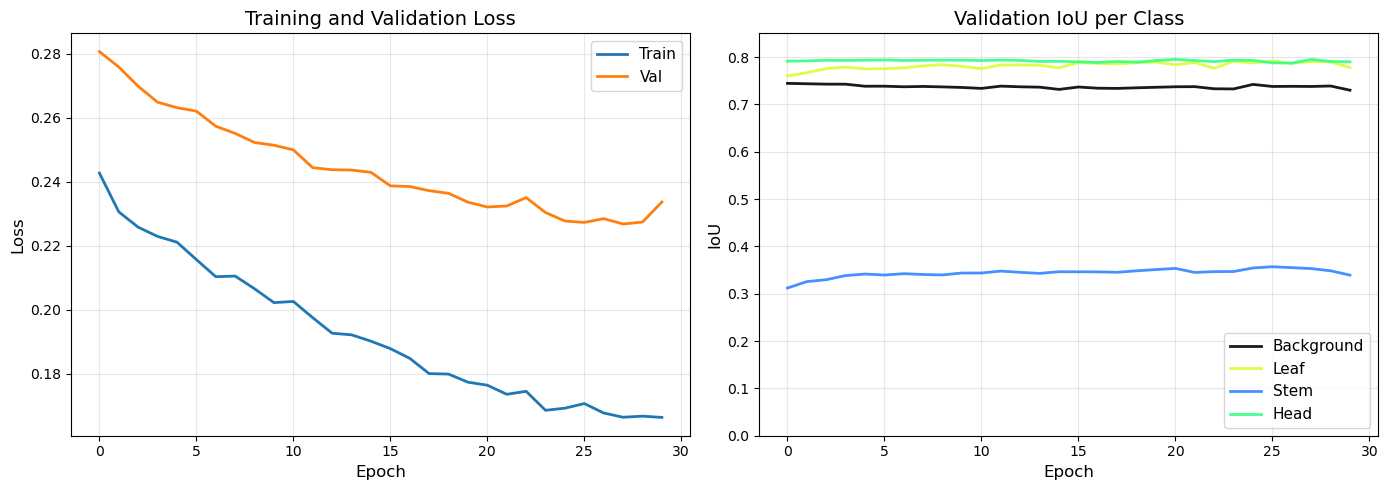

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Per-class IoU (validation only)
val_class_ious_array = np.array(history['val_class_ious'])

# Match the RGB mask colors
mask_colors = [
    '#000000',              # Background: Black
    '#D6FF32',              # Leaf: Yellow-green
    '#3284FF',              # Stem: Blue
    '#32FF84',              # Head: Cyan-green
]

for cls, name in enumerate(class_names):
    axes[1].plot(val_class_ious_array[:, cls], label=name, linewidth=2, 
                 color=mask_colors[cls], alpha=0.9)

# Add target lines
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('IoU', fontsize=12)
axes[1].set_title('Validation IoU per Class', fontsize=14)
axes[1].legend(fontsize=11, loc='lower right')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 0.85])

plt.tight_layout()
plt.show()

In [21]:
# Create experiment name
experiment_name = "02_dice_stem"

# Clean up any old versions of the experiment
old_files = glob.glob(f'./cache/{experiment_name}.pth') + glob.glob(f'./cache/{experiment_name}_summary.json')
for f in old_files:
    os.remove(f)
    print(f"✓ Removed old version: {f}")

# Load the best model that was saved during training
best_model_path = './cache/best_model.pth'
if os.path.exists(best_model_path):
    best_checkpoint = torch.load(best_model_path, weights_only=False)
    print(f"✓ Found best_model.pth from epoch {best_checkpoint['epoch']+1}")
else:
    print("⚠ No best_model.pth found, using current model state")
    best_checkpoint = {
        'epoch': best_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_miou': best_val_miou,
    }

# Save complete checkpoint
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_path = f'./cache/{experiment_name}.pth'
torch.save({
    'experiment_name': experiment_name,
    'timestamp': timestamp,
    'epoch': best_checkpoint['epoch'],
    'model_state_dict': best_checkpoint['model_state_dict'],
    'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
    'scheduler_state_dict': scheduler.state_dict(),
    'best_val_miou': best_val_miou,
    'final_val_miou': history['val_miou'][-1],
    'history': history,
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'image_size': 512,
        'encoder': 'resnet50',
        'loss': 'DiceLoss',
        'class_weights': class_weights,
    },
    'final_results': {
        'train_loss': history['train_loss'][-1],
        'val_loss': history['val_loss'][-1],
        'train_miou': history['train_miou'][-1],
        'val_miou': history['val_miou'][-1],
        'val_class_ious': history['val_class_ious'][-1],
    }
}, checkpoint_path)

print(f"✓ Saved complete checkpoint: {checkpoint_path}")

# Save summary as JSON
summary = {
    'experiment_name': experiment_name,
    'timestamp': timestamp,
    'best_epoch': int(best_epoch + 1),
    'total_epochs': len(history['train_loss']),
    'best_val_miou': float(best_val_miou),
    'final_val_miou': float(history['val_miou'][-1]),
    'final_val_class_ious': {
        'background': float(history['val_class_ious'][-1][0]),
        'leaf': float(history['val_class_ious'][-1][1]),
        'stem': float(history['val_class_ious'][-1][2]),
        'head': float(history['val_class_ious'][-1][3]),
    },
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'image_size': 512,
        'encoder': 'resnet50',
        'loss': 'DiceLoss',
        'class_weights': class_weights,
    },
    'training_time_minutes': 78,
}

summary_path = f'./cache/{experiment_name}_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved summary: {summary_path}")

# Delete best_model.pth
if os.path.exists(best_model_path):
    os.remove(best_model_path)
    print(f"✓ Cleaned up best_model.pth (archived in experiment file)")

# Print summary
print("\n" + "="*70)
print(f"EXPERIMENT SAVED: {experiment_name}")
print("="*70)
print(f"Timestamp: {timestamp}")
print(f"Best Val mIoU: {best_val_miou:.4f} (Epoch {best_epoch+1})")
print(f"Final Val mIoU: {history['val_miou'][-1]:.4f}")
print(f"Training time: 78 minutes")

✓ Removed old version: ./cache/02_dice_stem.pth
✓ Removed old version: ./cache/02_dice_stem_summary.json
✓ Found best_model.pth from epoch 25
✓ Saved complete checkpoint: ./cache/02_dice_stem.pth
✓ Saved summary: ./cache/02_dice_stem_summary.json
✓ Cleaned up best_model.pth (archived in experiment file)

EXPERIMENT SAVED: 02_dice_stem
Timestamp: 20251228_145534
Best Val mIoU: 0.6692 (Epoch 25)
Final Val mIoU: 0.6592
Training time: 78 minutes


Dice Loss improved stem segmentation but led to a drop in background IoU, and stem performance plateaued around epoch 10 despite continued training. For the next experiment, a combined loss function will be used to maintain Dice's benefit for stems whilst leveraging CrossEntropy's strength on the other classes.

### Combined Loss

In [22]:
# Create both loss functions
dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=NUM_CLASSES)
ce_loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Combine them with equal weighting
def combined_loss(outputs, targets):
    return 0.5 * dice_loss(outputs, targets) + 0.5 * ce_loss(outputs, targets)

criterion = combined_loss

print(f"✓ Using Combined Loss: (0.5 × Dice) + (0.5 × CrossEntropy)")

✓ Using Combined Loss: (0.5 × Dice) + (0.5 × CrossEntropy)


In [23]:
# Track training time
training_start_time = time.time()

# Track best model
best_val_miou = 0.0
best_epoch = 0

# Store history
history = {
    'train_loss': [],
    'train_miou': [],
    'val_loss': [],
    'val_miou': [],
    'train_class_ious': [],
    'val_class_ious': []
}

print(f"\nStarting training for up to {NUM_EPOCHS} epochs...")
print(f"Early stopping: patience = {PATIENCE} epochs\n")
print("=" * 80)

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_miou, train_class_ious = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_miou, val_class_ious = validate(
        model, val_loader, criterion, device
    )
    
    # Step scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_miou'].append(train_miou)
    history['val_loss'].append(val_loss)
    history['val_miou'].append(val_miou)
    history['train_class_ious'].append(train_class_ious)
    history['val_class_ious'].append(val_class_ious)
    
    # Track best model and early stopping
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        best_epoch = epoch
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_miou': val_miou,
        }, './cache/best_model.pth')
        best_marker = "⭐ Best model!"
    else:
        patience_counter += 1
        best_marker = ""
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.1f}s)")
    print(f"  Train Loss: {train_loss:.4f} | Train mIoU: {train_miou:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val mIoU:   {val_miou:.4f}")
    print(f"  Val IoUs - BG: {val_class_ious[0]:.3f}, Leaf: {val_class_ious[1]:.3f}, "
          f"Stem: {val_class_ious[2]:.3f}, Head: {val_class_ious[3]:.3f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f} | Patience: {patience_counter}/{PATIENCE}")
    if best_marker:
        print(f"  {best_marker}")
    print("-" * 80)
    
    # Check for early stopping
    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping triggered! No improvement for {PATIENCE} epochs.")
        print(f"Best Val mIoU: {best_val_miou:.4f} (Epoch {best_epoch+1})")
        break

print("\n" + "=" * 80)
print(f"Training complete!")
print(f"Best Val mIoU: {best_val_miou:.4f} (Epoch {best_epoch+1})")
print(f"Total epochs trained: {epoch+1}")


Starting training for up to 30 epochs...
Early stopping: patience = 10 epochs

Epoch [1/30] (154.6s)
  Train Loss: 0.3397 | Train mIoU: 0.6498
  Val Loss:   0.4431 | Val mIoU:   0.6120
  Val IoUs - BG: 0.727, Leaf: 0.695, Stem: 0.255, Head: 0.771
  LR: 0.000069 | Patience: 0/10
  ⭐ Best model!
--------------------------------------------------------------------------------
Epoch [2/30] (154.1s)
  Train Loss: 0.2833 | Train mIoU: 0.6734
  Val Loss:   0.4259 | Val mIoU:   0.6234
  Val IoUs - BG: 0.736, Leaf: 0.712, Stem: 0.266, Head: 0.780
  LR: 0.000072 | Patience: 0/10
  ⭐ Best model!
--------------------------------------------------------------------------------
Epoch [3/30] (153.9s)
  Train Loss: 0.2702 | Train mIoU: 0.6853
  Val Loss:   0.4250 | Val mIoU:   0.6368
  Val IoUs - BG: 0.736, Leaf: 0.737, Stem: 0.296, Head: 0.778
  LR: 0.000074 | Patience: 0/10
  ⭐ Best model!
--------------------------------------------------------------------------------
Epoch [4/30] (152.8s)
  Train

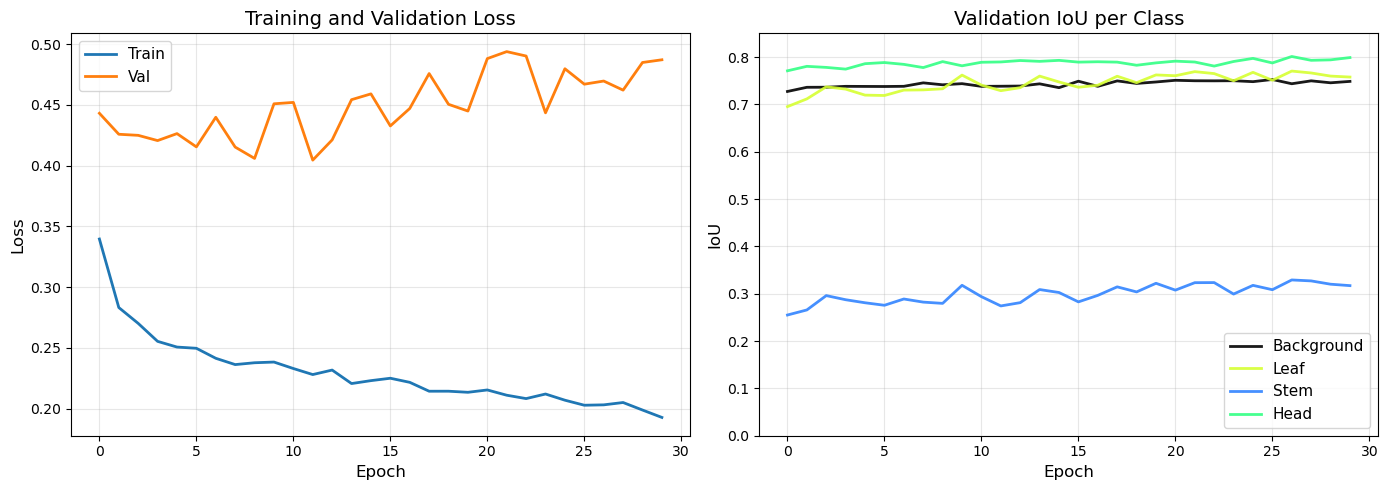

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Per-class IoU (validation only)
val_class_ious_array = np.array(history['val_class_ious'])

# Match the RGB mask colors
mask_colors = [
    '#000000',              # Background: Black
    '#D6FF32',              # Leaf: Yellow-green
    '#3284FF',              # Stem: Blue
    '#32FF84',              # Head: Cyan-green
]

for cls, name in enumerate(class_names):
    axes[1].plot(val_class_ious_array[:, cls], label=name, linewidth=2, 
                 color=mask_colors[cls], alpha=0.9)

# Add target lines
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('IoU', fontsize=12)
axes[1].set_title('Validation IoU per Class', fontsize=14)
axes[1].legend(fontsize=11, loc='lower right')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 0.85])

plt.tight_layout()
plt.show()

In [25]:
# Create experiment name
experiment_name = "03_combined_loss"

# Calculate actual training time
training_time_minutes = (time.time() - training_start_time) / 60

# Clean up any old versions of the experiment
old_files = glob.glob(f'./cache/{experiment_name}.pth') + glob.glob(f'./cache/{experiment_name}_summary.json')
for f in old_files:
    os.remove(f)
    print(f"✓ Removed old version: {f}")

# Load the best model that was saved during training
best_model_path = './cache/best_model.pth'
if os.path.exists(best_model_path):
    best_checkpoint = torch.load(best_model_path, weights_only=False)
    print(f"✓ Found best_model.pth from epoch {best_checkpoint['epoch']+1}")
else:
    print("⚠ No best_model.pth found, using current model state")
    best_checkpoint = {
        'epoch': best_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_miou': best_val_miou,
    }

# Save complete checkpoint
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_path = f'./cache/{experiment_name}.pth'
torch.save({
    'experiment_name': experiment_name,
    'timestamp': timestamp,
    'epoch': best_checkpoint['epoch'],
    'model_state_dict': best_checkpoint['model_state_dict'],
    'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
    'scheduler_state_dict': scheduler.state_dict(),
    'best_val_miou': best_val_miou,
    'final_val_miou': history['val_miou'][-1],
    'history': history,
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'image_size': 512,
        'encoder': 'resnet50',
        'loss': 'Combined_Dice_CE',
        'class_weights': class_weights,
    },
    'final_results': {
        'train_loss': history['train_loss'][-1],
        'val_loss': history['val_loss'][-1],
        'train_miou': history['train_miou'][-1],
        'val_miou': history['val_miou'][-1],
        'val_class_ious': history['val_class_ious'][-1],
    }
}, checkpoint_path)

print(f"✓ Saved complete checkpoint: {checkpoint_path}")

# Save summary as JSON
summary = {
    'experiment_name': experiment_name,
    'timestamp': timestamp,
    'best_epoch': int(best_epoch + 1),
    'total_epochs': len(history['train_loss']),
    'best_val_miou': float(best_val_miou),
    'final_val_miou': float(history['val_miou'][-1]),
    'final_val_class_ious': {
        'background': float(history['val_class_ious'][-1][0]),
        'leaf': float(history['val_class_ious'][-1][1]),
        'stem': float(history['val_class_ious'][-1][2]),
        'head': float(history['val_class_ious'][-1][3]),
    },
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'batch_size': BATCH_SIZE,
        'num_epochs': NUM_EPOCHS,
        'image_size': 512,
        'encoder': 'resnet50',
        'loss': 'Combined_Dice_CE',
        'class_weights': class_weights,
    },
    'training_time_minutes': round(training_time_minutes)
}

summary_path = f'./cache/{experiment_name}_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved summary: {summary_path}")

# Delete best_model.pth
if os.path.exists(best_model_path):
    os.remove(best_model_path)
    print(f"✓ Cleaned up best_model.pth (archived in experiment file)")

# Print summary
print("\n" + "="*70)
print(f"EXPERIMENT SAVED: {experiment_name}")
print("="*70)
print(f"Timestamp: {timestamp}")
print(f"Best Val mIoU: {best_val_miou:.4f} (Epoch {best_epoch+1})")
print(f"Final Val mIoU: {history['val_miou'][-1]:.4f}")
print(f"Training time: {round(training_time_minutes)} minutes") 

✓ Removed old version: ./cache/03_combined_loss.pth
✓ Removed old version: ./cache/03_combined_loss_summary.json
✓ Found best_model.pth from epoch 27
✓ Saved complete checkpoint: ./cache/03_combined_loss.pth
✓ Saved summary: ./cache/03_combined_loss_summary.json
✓ Cleaned up best_model.pth (archived in experiment file)

EXPERIMENT SAVED: 03_combined_loss
Timestamp: 20251228_161300
Best Val mIoU: 0.6610 (Epoch 27)
Final Val mIoU: 0.6555
Training time: 77 minutes


The combined loss function resulted in training instability and overfitting, with validation loss increasing despite decreasing training loss. Of the three experiments, the second (Dice Loss with increased stem class weighting) proved most effective, primarily through better stem segmentation. While hyperparameter tuning may yield minor performance gains, meaningful improvements would likely require architectural changes and stronger data augmentation.